In [1]:
install.packages("ggraph")
install.packages("igraph")
install.packages("graphframes")

In [1]:
library(sparklyr)
library(dplyr)
library(ggraph)
library(igraph)
library(graphframes)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'ggraph' was built under R version 3.6.3"
Loading required package: ggplot2

Warning message:
"package 'igraph' was built under R version 3.6.3"

Attaching package: 'igraph'


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union


Warning message:
"package 'graphframes' was built under R version 3.6.3"


In [2]:
head(highschool)

,from,to,year
,<dbl>,<dbl>,<dbl>
1,1,14,1957
2,1,15,1957
3,1,21,1957
4,1,54,1957
5,1,55,1957
6,2,21,1957


In [3]:
ggraph::highschool

,from,to,year
,<dbl>,<dbl>,<dbl>
1,1,14,1957
2,1,15,1957
3,1,21,1957
4,1,54,1957
5,1,55,1957
6,2,21,1957
7,2,22,1957
8,3,9,1957
9,3,15,1957


In [4]:
Sys.setenv(JAVA_HOME="C:/Java/jre1.8.0_221") #you need to change to your path
Sys.setenv(SPARK_HOME="C:/spark-2.4.4-bin-hadoop2.7") #you need to change to your path

### if you see error
### Exception in thread "main" java.lang.RuntimeException: [unresolved dependency: graphframes#graphframes;0.6.0-spark2.4-s_2.11: not found]
### please go to http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.6.0-spark2.3-s_2.11/graphframes-0.6.0-spark2.3-s_2.11.jar
### rename it to graphframes.jar and then store it to 
### C:\Users\YOUR USERNAME\\.ivy2\local\graphframes\graphframes\0.6.0-spark2.4-s_2.11\jars

In [5]:
sc=spark_connect(master = "local")
highschool_tbl <- copy_to(sc, highschool, "highschool", overwrite = TRUE)

In [6]:
highschool_tbl

# Source: spark<highschool> [?? x 3]
    from    to  year
   <dbl> <dbl> <dbl>
 1     1    14  1957
 2     1    15  1957
 3     1    21  1957
 4     1    54  1957
 5     1    55  1957
 6     2    21  1957
 7     2    22  1957
 8     3     9  1957
 9     3    15  1957
10     4     5  1957
# ... with more rows

In [35]:
highschool_tbl <- copy_to(sc, 
                          highschool, 
                          "highschool", 
                          overwrite = TRUE) %>%
  filter(year == 1957) %>%
  transmute(from = as.character(as.integer(from)),
            to = as.character(as.integer(to)))

In [36]:
highschool_tbl

# Source: spark<?> [?? x 2]
   from  to   
   <chr> <chr>
 1 1     14   
 2 1     15   
 3 1     21   
 4 1     54   
 5 1     55   
 6 2     21   
 7 2     22   
 8 3     9    
 9 3     15   
10 4     5    
# ... with more rows

In [37]:
from_tbl <- highschool_tbl %>% 
    distinct(from) %>% 
    transmute(id = from)
from_tbl

# Source: spark<?> [?? x 1]
   id   
   <chr>
 1 1    
 2 3    
 3 4    
 4 8    
 5 12   
 6 17   
 7 20   
 8 27   
 9 29   
10 31   
# ... with more rows

In [38]:
to_tbl <- highschool_tbl %>% 
    distinct(to) %>% 
    transmute(id = to)
to_tbl

# Source: spark<?> [?? x 1]
   id   
   <chr>
 1 43   
 2 20   
 3 17   
 4 12   
 5 8    
 6 4    
 7 27   
 8 60   
 9 65   
10 68   
# ... with more rows

In [39]:
vertices_tbl <- distinct(sdf_bind_rows(from_tbl, to_tbl))
vertices_tbl

# Source: spark<?> [?? x 1]
   id   
   <chr>
 1 1    
 2 3    
 3 4    
 4 8    
 5 12   
 6 17   
 7 20   
 8 27   
 9 29   
10 31   
# ... with more rows

In [40]:
edges_tbl <- highschool_tbl %>% 
    transmute(src = from, dst = to)
edges_tbl

# Source: spark<?> [?? x 2]
   src   dst  
   <chr> <chr>
 1 1     14   
 2 1     15   
 3 1     21   
 4 1     54   
 5 1     55   
 6 2     21   
 7 2     22   
 8 3     9    
 9 3     15   
10 4     5    
# ... with more rows

In [58]:
filter(edges_tbl, dst==14)

# Source: spark<?> [?? x 2]
  src   dst  
  <chr> <chr>
1 1     14   
2 8     14   

In [60]:
filter(edges_tbl, src==29)
filter(edges_tbl, src==13)

# Source: spark<?> [?? x 2]
  src   dst  
  <chr> <chr>
1 29    13   
2 29    38   

# Source: spark<?> [?? x 2]
  src   dst  
  <chr> <chr>
1 13    17   
2 13    20   
3 13    21   
4 13    22   

### put scala-logging-slf4j_2.10-2.1.2.jar into C:\Java\jre1.8.0_221\lib\ext or your JAVA_HOME's same folder
### You can download this file on canvas W7 page. DO NOT download elsewhere because I modified this jar to make life easier.

In [41]:
graph <- gf_graphframe(vertices_tbl, edges_tbl)
graph

GraphFrame
Vertices:
  Database: spark_connection
  $ id <chr> "1", "3", "4", "8", "12", "17", "20", "27", "29", "31", "34", "3...
Edges:
  Database: spark_connection
  $ src <chr> "1", "1", "1", "1", "1", "2", "2", "3", "3", "4", "4", "4", "4"...
  $ dst <chr> "14", "15", "21", "54", "55", "21", "22", "9", "15", "5", "18",...

In [42]:
?gf_degrees

In [43]:
gf_degrees(graph)

# Source: spark<?> [?? x 2]
   id    degree
   <chr>  <int>
 1 1          5
 2 3          2
 3 4          5
 4 43        12
 5 20        11
 6 17         5
 7 8          3
 8 12         5
 9 27         4
10 60         7
# ... with more rows

In [44]:
gf_degrees(graph) %>% arrange(desc(degree))

# Source:     spark<?> [?? x 2]
# Ordered by: desc(degree)
   id    degree
   <chr>  <int>
 1 71        16
 2 21        14
 3 22        14
 4 70        13
 5 54        13
 6 69        12
 7 43        12
 8 66        12
 9 52        11
10 67        11
# ... with more rows

In [45]:
gf_degrees(graph) %>% summarise(friends = mean(degree, na.rm = TRUE))

# Source: spark<?> [?? x 1]
  friends
    <dbl>
1    6.94

In [56]:
gf_shortest_paths(graph, 14)

# Source: spark<?> [?? x 2]
   id    distances       
   <chr> <list>          
 1 17    <named list [1]>
 2 27    <named list [0]>
 3 29    <named list [1]>
 4 34    <named list [1]>
 5 43    <named list [0]>
 6 45    <named list [0]>
 7 47    <named list [0]>
 8 49    <named list [0]>
 9 56    <named list [0]>
10 57    <named list [0]>
# ... with more rows

In [61]:
gf_shortest_paths(graph, 14) %>%
  filter(size(distances) > 0) %>%
  mutate(distance = explode(map_values(distances))) %>%
  select(id, distance) 

# Source: spark<?> [?? x 2]
   id    distance
   <chr>    <int>
 1 17           2
 2 29           4
 3 34           6
 4 8            1
 5 13           3
 6 14           0
 7 22           6
 8 24           8
 9 28           6
10 38           7
# ... with more rows

In [63]:
gf_shortest_paths(graph, 14) %>%
    filter(size(distances) > 0) %>%
    mutate(distance = explode(map_values(distances))) %>%
    select(id, distance) %>% 
    summarise(influence = mean(distance, na.rm = TRUE))

# Source: spark<?> [?? x 1]
  influence
      <dbl>
1      4.96

In [64]:
gf_shortest_paths(graph, 33) %>%
    filter(size(distances) > 0) %>%
    mutate(distance = explode(map_values(distances))) %>%
    select(id, distance) %>% 
    summarise(influence = mean(distance, na.rm = TRUE))

# Source: spark<?> [?? x 1]
  influence
      <dbl>
1      3.33

In [54]:
?gf_shortest_paths

In [18]:
gf_graphframe(vertices_tbl, edges_tbl) %>%
  gf_pagerank(reset_prob = 0.15, max_iter = 10L)

GraphFrame
Vertices:
  Database: spark_connection
  $ id       <chr> "17", "27", "29", "34", "43", "45", "47", "49", "56", "57"...
  $ pagerank <dbl> 0.9584287, 0.2465494, 0.2567435, 0.3430992, 1.0834154, 0.8...
Edges:
  Database: spark_connection
  $ src    <chr> "1", "1", "12", "20", "20", "20", "27", "29", "3", "31", "31...
  $ dst    <chr> "15", "21", "20", "12", "21", "22", "40", "38", "15", "37", ...
  $ weight <dbl> 0.2000000, 0.2000000, 0.3333333, 0.2000000, 0.2000000, 0.200...

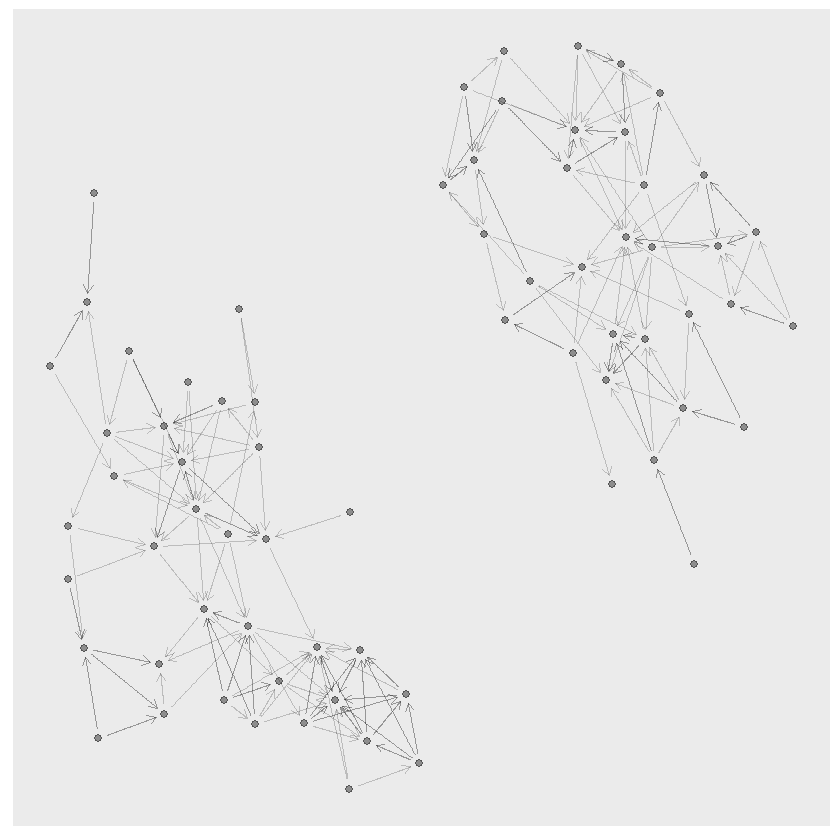

In [66]:
library(ggraph)
highschool_tbl %>%
  igraph::graph_from_data_frame(directed = FALSE) %>%
  ggraph(layout = 'kk') + 
    geom_edge_link(alpha = 0.2,
                   arrow = arrow(length = unit(2, 'mm')),
                   end_cap = circle(2, 'mm'),
                   start_cap = circle(2, 'mm')) + 
    geom_node_point(size = 2, alpha = 0.4)